<a href="https://colab.research.google.com/github/Ronilmuchandi/economics-of-remote-work-city-opportunity/blob/main/notebooks/06_evaluation_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/drive/MyDrive/master_msa_dataset_final.csv")

base_vars = [
    "remote_share",
    "gross_migration",
    "total_cost",
    "median_family_income"
]

scaler = StandardScaler()
df_m = df.copy()
df_m[[f"{v}_z" for v in base_vars]] = scaler.fit_transform(df[base_vars])

df_m["RWDI"] = df_m["remote_share_z"]
df_m["MIS"]  = df_m["gross_migration_z"]
df_m["CPI"]  = df_m["total_cost_z"]
df_m["RWOI"] = (df_m["RWDI"] + df_m["MIS"]) / 2
df_m["RWFI"] = df_m["RWOI"] * df_m["CPI"] * df_m["MIS"]

df_m.shape


(209, 41)

In [7]:
# Median-based thresholds (robust for evaluation)
rwoi_med = df_m["RWOI"].median()
rwfi_med = df_m["RWFI"].median()

emerging_cities = df_m[
    (df_m["RWOI"] > rwoi_med) &
    (df_m["RWFI"] <= rwfi_med)
][["city_state", "RWOI", "RWFI", "CPI", "MIS"]].sort_values(
    "RWOI", ascending=False
)

emerging_cities.head(15)



,city_state,RWOI,RWFI,CPI,MIS
54,"el centro, ca",2.450990,-0.383307,0.219187,-0.713492
52,"east stroudsburg, pa",2.130628,-0.445167,0.514492,-0.406103
207,"yuba city, ca",1.749470,-1.000201,1.250105,-0.457335
188,"tucson, az",1.186983,-2.996181,-0.859282,2.937570
151,"punta gorda, fl",1.044225,-0.040952,0.187980,-0.208629
89,"ithaca, ny",0.737424,-0.379022,1.723184,-0.298274
178,"state college, pa",0.727859,-0.036818,0.986683,-0.051267
118,"madera, ca",0.714882,-0.587025,1.646891,-0.498606
55,"elmira, ny",0.536903,-0.148441,0.323530,-0.854562
124,"merced, ca",0.442846,-0.035746,0.597558,-0.135082


In [8]:
least_favorable = df_m[
    (df_m["RWOI"] <= rwoi_med) &
    (df_m["RWFI"] > rwfi_med)
][["city_state", "RWOI", "RWFI", "CPI", "MIS"]].sort_values(
    "RWFI", ascending=False
)

least_favorable.head(15)


,city_state,RWOI,RWFI,CPI,MIS
137,"napa, ca",-0.562458,1.378991,4.489894,-0.546054
77,"grants pass, or",-0.885896,0.872149,1.311808,-0.750478
101,"kingston, ny",-0.310072,0.278739,1.643591,-0.546942
73,"glens falls, ny",-0.847501,0.265841,0.465609,-0.673688
133,"morgantown, wv",-0.624383,0.187247,0.823217,-0.364292
155,"redding, ca",-0.328405,0.186591,1.221624,-0.465095
168,"san angelo, tx",-0.446007,0.159476,0.711178,-0.502775
72,"gettysburg, pa",-0.381591,0.158100,0.600479,-0.689981
41,"columbus, in",-0.914716,0.136244,0.184313,-0.808118
200,"wenatchee, wa",-0.492601,0.103530,0.282227,-0.744687


In [9]:
import plotly.express as px

plot_df = df_m.dropna(subset=["RWFI"]).copy()

plot_df["group"] = "Other Cities"
plot_df.loc[
    plot_df["city_state"].isin(emerging_cities["city_state"]),
    "group"
] = "Emerging / Favorable"

plot_df.loc[
    plot_df["city_state"].isin(least_favorable["city_state"]),
    "group"
] = "High Risk / Low Opportunity"

fig = px.scatter(
    plot_df,
    x="RWOI",
    y="RWFI",
    color="group",
    hover_name="city_state",
    title="Step 7 Validation: Opportunity vs Fragility with City Groups",
    labels={
        "RWOI": "Remote Work Opportunity Index",
        "RWFI": "Remote Work Fragility Index"
    }
)

fig.add_hline(y=rwfi_med, line_dash="dash")
fig.add_vline(x=rwoi_med, line_dash="dash")

fig.show()


In [14]:
import plotly.express as px

# Work only where fragility exists
state_df = df_m.dropna(subset=["RWFI"]).copy()

# Classify each MSA
state_df["region_type"] = "Neutral / Transitional"

state_df.loc[
    (state_df["RWOI"] > rwoi_med) & (state_df["RWFI"] <= rwfi_med),
    "region_type"
] = "Emerging / Favorable"

state_df.loc[
    (state_df["RWOI"] <= rwoi_med) & (state_df["RWFI"] > rwfi_med),
    "region_type"
] = "High Risk / Fragile"

# Aggregate to state level using dominant regime
state_regime = (
    state_df
    .groupby(["msa_state", "region_type"])
    .size()
    .reset_index(name="count")
)

state_regime = (
    state_regime
    .sort_values("count", ascending=False)
    .groupby("msa_state")
    .first()
    .reset_index()
)

# Color mapping
color_map = {
    "Emerging / Favorable": "green",
    "Neutral / Transitional": "blue",
    "High Risk / Fragile": "red"
}

# Plot choropleth
fig = px.choropleth(
    state_regime,
    locations="msa_state",
    locationmode="USA-states",
    color="region_type",
    color_discrete_map=color_map,
    scope="usa",
    title="Step 7 Validation: U.S. States by Remote Work Structural Regime"
)

fig.show()


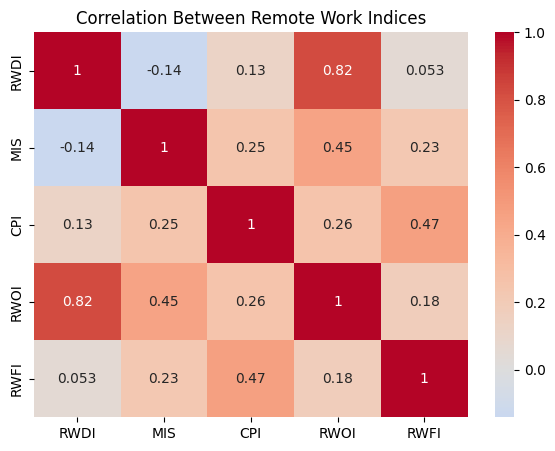

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_vars = df_m[["RWDI", "MIS", "CPI", "RWOI", "RWFI"]].dropna()

plt.figure(figsize=(7, 5))
sns.heatmap(
    corr_vars.corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Between Remote Work Indices")
plt.show()


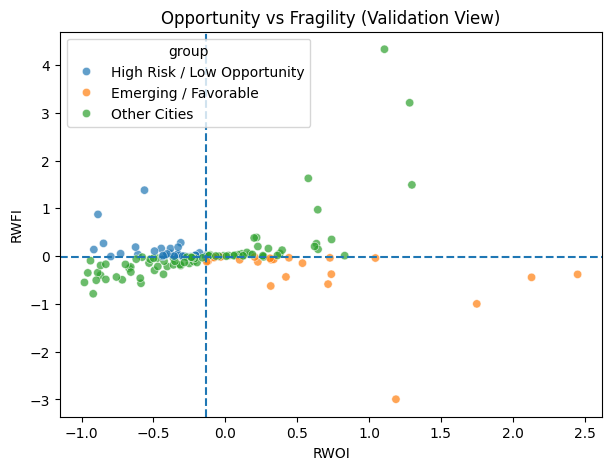

In [12]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=map_df,
    x="RWOI",
    y="RWFI",
    hue="group",
    alpha=0.7
)
plt.axhline(rwfi_med, linestyle="--")
plt.axvline(rwoi_med, linestyle="--")
plt.title("Opportunity vs Fragility (Validation View)")
plt.show()
